In [24]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
import seaborn as sns
from joblib import dump
import matplotlib.pyplot as plt

In [4]:
# Read all the datasets
df1 = pd.read_csv("./dataset/gossipcop_real.csv", usecols = ['title'])
df2 = pd.read_csv("./dataset/politifact_real.csv", usecols = ['title'])
df3 = pd.read_csv("./dataset/gossipcop_fake.csv", usecols = ['title'])
df4 = pd.read_csv("./dataset/politifact_fake.csv", usecols = ['title'])

In [5]:
# Combine real and fake data into separate datasets
df_real = pd.concat([df1, df2], axis=0)
df_fake = pd.concat([df3, df4], axis=0)

In [6]:
# Check for empty and NA values
df_real[df_real.loc[:,:] == ' '] = np.NaN
print(df_real.isna().sum())
df_fake[df_fake.loc[:,:] == ' '] = np.NaN
print(df_fake.isna().sum())

title    0
dtype: int64
title    0
dtype: int64


In [7]:
# Remove sentences having less than 5 words
df_real = df_real[~df_real.title.str.count('\s+').lt(4)]

# Add label column for real news
df_real['label'] = 0
df_real

,title,label
0,Teen Mom Star Jenelle Evans' Wedding Dress Is ...,0
1,Kylie Jenner refusing to discuss Tyga on Life ...,0
3,I Tried Kim Kardashian's Butt Workout & Am For...,0
4,Celine Dion donates concert proceeds to Vegas ...,0
5,"Chris Evans, Millie Bobby Brown, Snoop Dogg an...",0
...,...,...
618,"Trump asking Congress, not Mexico, to pay for ...",0
619,Flake: “Religious tests should have no place i...,0
620,Change We Can Believe In,0
621,deputy director of national health statistics ...,0


In [8]:
# Remove sentences having less than 5 words
df_fake = df_fake[~df_fake.title.str.count('\s+').lt(4)]

# Add label column for fake news
df_fake['label'] = 1
df_fake

,title,label
0,Did Miley Cyrus and Liam Hemsworth secretly ge...,1
1,Paris Jackson & Cara Delevingne Enjoy Night Ou...,1
2,Celebrities Join Tax March in Protest of Donal...,1
3,Cindy Crawford's daughter Kaia Gerber wears a ...,1
4,Full List of 2018 Oscar Nominations – Variety,1
...,...,...
426,BUSTED: Russian Mansions Obama Seized Were Mea...,1
427,Who is affected by the government shutdown?,1
428,Lindsey Graham Threatens To Convert To Democra...,1
429,ELECTORAL COLLEGE ELECTOR COMMITS SUICIDE TO A...,1


In [9]:
# Combine both the real and fake news dataset
df = pd.concat([df_real, df_fake])

# Shuffle the final dataset
df = df.sample(frac=1)
df

,title,label
15032,E! News Exclusive: Behati Prinsloo Describes M...,0
10518,Khloé helped me lose 50 pounds to get revenge ...,0
9265,Serena Williams' Regal Ponytail Is Easier Than...,0
6727,‘Bachelor in Paradise’ Returned for Season 4 W...,0
1033,Suri Cruise Is Turning 12 And Looks Just Like ...,1
...,...,...
11108,Game of Thrones (season 8),0
13461,Jennifer Aniston and Justin Theroux Split 'Lov...,0
7730,We Are Living for Jennifer Lopez's Latest Outfit,0
4069,Melania and Donald Trump Match Outfits and Mor...,0


In [10]:
# Count the distinct label values
df.label.value_counts()

label
0    16460
1     5433
Name: count, dtype: int64

In [11]:
# Download stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sasha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
# Download WordNet (lexical database for English language)
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sasha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
# Text preprocessing
def preprocessing(tweet):
  text = BeautifulSoup(tweet).get_text() # Remove HTML tags
  text = re.sub("[^a-zA-Z#]", " ", text) # Remove special characters
  text = re.sub('((www.[^s]+)|(https?://[^s]+))',' ', text) # Remove URLs
  text = text.lower().split() # Convert to lowercase and split each word

  stop_w = set(stopwords.words("english")) # Use a set instead of list for faster searching
  text = [w for w in text if not w in stop_w] # Remove stop words
  text = [WordNetLemmatizer().lemmatize(w) for w in text] # Lemmatization

  return (" ".join(text)) # Return the words after joining each word separated by space

In [14]:
# Clean the textual data
df['title'] = df['title'].apply(lambda text: preprocessing(text))
df['title'].head()

C:\Users\sasha\AppData\Local\Temp\ipykernel_21024\3237034733.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(tweet).get_text() # Remove HTML tags


15032    e news exclusive behati prinsloo describes mot...
10518                khlo helped lose pound get revenge ex
9265     serena williams regal ponytail easier think re...
6727     bachelor paradise returned season highest rati...
1033        suri cruise turning look like mom katie holmes
Name: title, dtype: object

In [15]:
# Split into train and test sets
train, test = train_test_split(df, test_size = 0.2, stratify = df['label'], random_state = 42)

# Get the shape of datasets after splitting
train.shape, test.shape

((17514, 2), (4379, 2))

In [16]:
# Create a TF-IDF vectorizer object
tfidf_vec = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))

# Data fitting and transformation
train_df = tfidf_vec.fit_transform(train.title)
test_df  = tfidf_vec.transform(test.title)

In [17]:
# Before over-sampling the minority class
train['label'].value_counts()

label
0    13168
1     4346
Name: count, dtype: int64

In [18]:
# Use SMOTE (Synthetic Minority Oversampling Technique) for dealing with class imbalance
smt = SMOTE(random_state = 18, sampling_strategy = 1.0)
smt_xtrain_df, smt_ytrain = smt.fit_resample(train_df, train.label)

In [19]:
# After over-sampling the minority class
smt_ytrain.value_counts()

label
0    13168
1    13168
Name: count, dtype: int64

              precision    recall  f1-score   support

    Negative       0.90      0.85      0.88      3292
    Positive       0.62      0.72      0.67      1087

    accuracy                           0.82      4379
   macro avg       0.76      0.79      0.77      4379
weighted avg       0.83      0.82      0.83      4379

Accuracy Score :  0.8218771408997488
[[2811  481]
 [ 299  788]]


Text(0.5, 427.9555555555555, 'Predicted label')

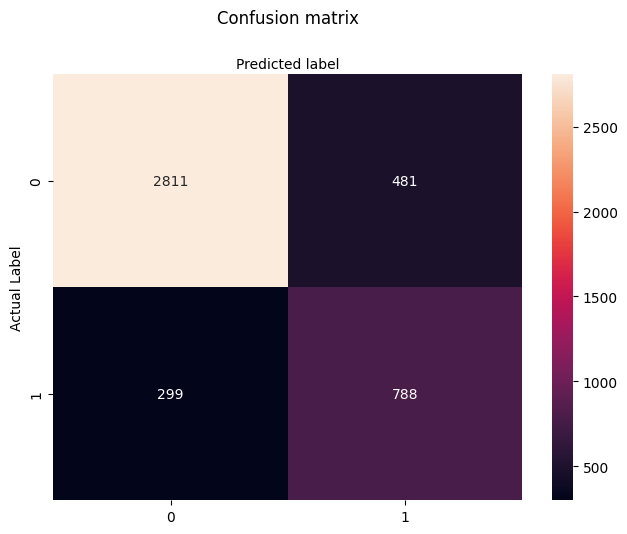

In [31]:
# Model 1 - Logistic Regressor
logis_reg = LogisticRegression()
logis_reg.fit(smt_xtrain_df, smt_ytrain)

y_pred = logis_reg.predict(test_df)

# Evaluation metrics
print(classification_report(test.label, y_pred, target_names=['Negative', 'Positive']))
print("Accuracy Score : ",accuracy_score(test.label, y_pred)  )
cnf_matrix = metrics.confusion_matrix(test.label, y_pred)
print(cnf_matrix)
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted label')

              precision    recall  f1-score   support

    Negative       0.90      0.85      0.88      3292
    Positive       0.61      0.71      0.66      1087

    accuracy                           0.82      4379
   macro avg       0.76      0.78      0.77      4379
weighted avg       0.83      0.82      0.82      4379

Accuracy Score :  0.8168531628225623
[[2808  484]
 [ 318  769]]


Text(0.5, 427.9555555555555, 'Predicted label')

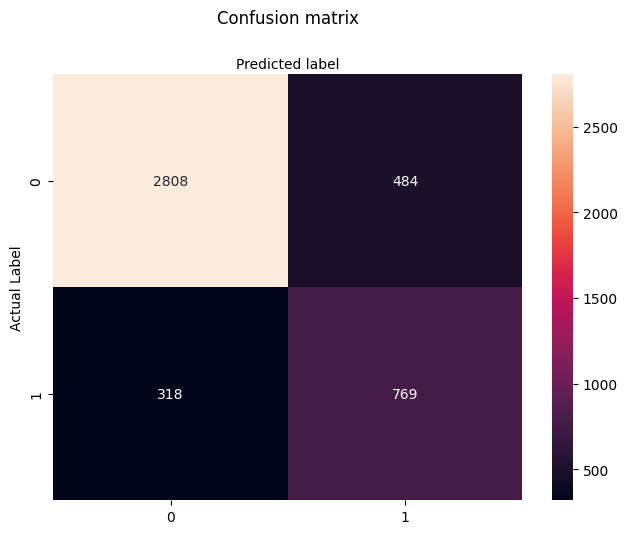

In [30]:
# Model 2 - Linear Support Vector Classifier
linear_svc = LinearSVC()
linear_svc.fit(smt_xtrain_df, smt_ytrain)

y_pred = linear_svc.predict(test_df)

# Evaluation metrics
print(classification_report(test.label, y_pred, target_names=['Negative', 'Positive']))
print("Accuracy Score : ", accuracy_score(test.label, y_pred))
cnf_matrix = metrics.confusion_matrix(test.label, y_pred)
print(cnf_matrix)
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted label')

In [ ]:
# Define the steps of the pipeline
pipeline = imbpipeline(steps = [['tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 3))],
                                ['smote', SMOTE(random_state = 18, sampling_strategy = 1.0)],
                                ['classifier', LogisticRegression()]])

# Fit the pipeline model with the training data                            
pipeline.fit(train.title, train.label)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 3))),
                ('smote', SMOTE(random_state=18, sampling_strategy=1.0)),
                ['classifier', LogisticRegression()]])

In [ ]:
# Predict the label using the pipeline
check = pipeline.predict(['BREAKING: FIFA Declares Bankruptcy Over Lack Of Sponsorships'])

out = "Fake News" if check==1 else "Real News"
print(out)

Fake News


In [ ]:
# Dump the pipeline model
dump(pipeline, filename = "fake_news_classification.joblib")

['fake_news_classification.joblib']

<Axes: xlabel='label', ylabel='count'>

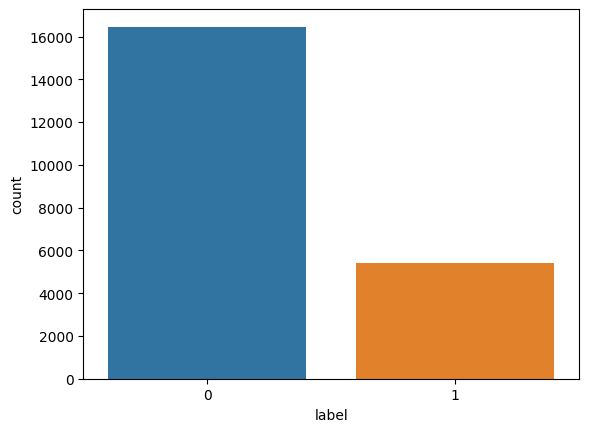

In [ ]:
sns.countplot(x='label', data=df)